# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


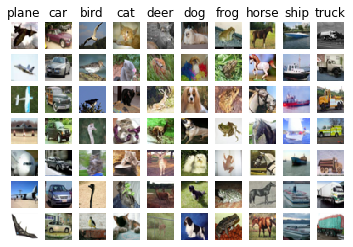

In [2]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../datasets/cifar10'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original dataset.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original dataset.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # Our test set will be num_test points from the original dataset.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength. You can 
# reuse the softmax_hyperparameter_tuning that you implemented in
# exercise_code.classifiers.softmax

from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax = None

################################################################################
# TODO: Train a softmax classifier on the features and tune hyperparameters to #
# obtain a strong model. You can alter and reuse the                           #
# softmax_hyperparameter_tuning function. Store your best network in the       #
# best_softmax variable.                                                       #
################################################################################

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train_feats, y_train, X_val_feats, y_val)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

/Users/tstoican/tum-sem1/DL/exercise_1/exercise_code/classifiers/softmax.py:92: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(correct_class_scores)) / X.shape[0]
/Users/tstoican/tum-sem1/DL/exercise_1/exercise_code/classifiers/softmax.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss += reg / 2 * np.sum(W ** 2)
/Users/tstoican/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tstoican/tum-sem1/DL/exercise_1/exercise_code/classifiers/softmax.py:93: RuntimeWarning: overflow encountered in square
  loss += reg / 2 * np.sum(W ** 2)
/Users/tstoican/tum-sem1/DL/exercise_1/exercise_code/classifiers/softmax.py:101: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
/Users/tstoican/tum-sem1/DL/exercise_1/exercise_code/classifiers/softmax.py:86: RuntimeWarning: invalid value encountered in matmul
  line

lr 1.000000e-07 reg 1.000000e-01 train accuracy: 0.134063 val accuracy: 0.121000
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.096833 val accuracy: 0.093000
lr 1.000000e-07 reg 5.000000e+01 train accuracy: 0.093292 val accuracy: 0.099000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.080479 val accuracy: 0.089000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.088646 val accuracy: 0.078000
lr 1.000000e-06 reg 1.000000e-01 train accuracy: 0.124292 val accuracy: 0.123000
lr 1.000000e-06 reg 1.000000e+01 train accuracy: 0.163333 val accuracy: 0.169000
lr 1.000000e-06 reg 5.000000e+01 train accuracy: 0.128042 val accuracy: 0.115000
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.117062 val accuracy: 0.139000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.412792 val accuracy: 0.422000
lr 1.000000e-05 reg 1.000000e-01 train accuracy: 0.262229 val accuracy: 0.238000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.299458 val accuracy: 0.279000
lr 1.000000e-05 reg 5.000000

In [5]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.436


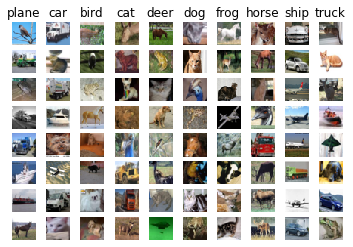

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned and behave almost the same as having a single bias term.

In [24]:
from exercise_code.classifiers.neural_net import TwoLayerNet

def neuralnetwork_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    best_net = None # store the best model into this
    best_acc = -np.inf
    
    input_size = X_train.shape[1]
    hidden_sizes = [256]
    lrs = [1e-1]
    regs = [0.001]

    ############################################################################
    # TODO: Tune hyperparameters using the validation set. Store your best     #
    # trained model in best_net.                                               #
    #                                                                          #
    # To help debug your network, it may help to use visualizations similar to #
    # the  ones we used above in the Jupyther Notebook; these visualizations   #
    # will have significant qualitative differences from the ones we saw for   #
    # the poorly tuned network.                                                #
    #                                                                          #
    # Tweaking hyperparameters by hand can be fun, but you might find it useful#
    # to  write code to sweep through possible combinations of hyperparameters #
    # automatically like we did on the previous exercises.                     #
    ############################################################################
    for hidden_size in hidden_sizes:
        for lr in lrs:
            for reg in regs:
                model = TwoLayerNet(input_size, hidden_size, 10)
                stats = model.train(X_train, y_train, X_val, y_val, num_iters=4000, batch_size=200, learning_rate=lr, learning_rate_decay=0.95, reg=reg, verbose=False)

                train_acc = np.mean(model.predict(X_train) == y_train)
                val_acc = np.mean(model.predict(X_val) == y_val)

                print('lr %e hidden_size %e train accuracy: %f val accuracy: %f reg: %f' % (
                  lr, hidden_size, train_acc, val_acc, reg))

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_net = model

    ############################################################################
    #                               END OF YOUR CODE                           #
    ############################################################################
    return best_net

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best         #
# model in the best_net variable.                                              #
################################################################################

best_net = neuralnetwork_hyperparameter_tuning(X_train_feats, y_train, X_val_feats, y_val)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.000000e-01 hidden_size 2.560000e+02 train accuracy: 0.597313 val accuracy: 0.565000 reg: 0.001000


In [25]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.562


## Save the model

When you are satisfied with your training you can save your model. 
You need to get a score of at least **55%** to pass this submission.
<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle ...</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [26]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)